<a href="https://colab.research.google.com/github/romqn1999/Resume-Parser-Tool/blob/main/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sbhawal/resumeScraper.git

fatal: destination path 'resumeScraper' already exists and is not an empty directory.


In [2]:
# %cd resumeScraper/data/INFORMATION-TECHNOLOGY

In [3]:
%pip install PyMuPDF pytesseract

In [4]:
import getpass
import os

# if "TOGETHER_API_KEY" not in os.environ:
#     os.environ["TOGETHER_API_KEY"] = getpass.getpass("Enter your Together API key: ")
os.environ["AZURE_OPENAI_DEPLOYMENT"] = "gpt-4.1"
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY") or getpass.getpass("Azure API key:")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT") or getpass.getpass("Azure endpoint:")
os.environ["OPENAI_API_VERSION"] = "2025-04-01-preview"

Azure API key:··········
Azure endpoint:··········


In [24]:
# %pip install -qU langchain-together
%pip install -qU langchain-openai

In [25]:
import pymupdf
import pytesseract
from PIL import Image
import io

def extract_text_from_pdf(pdf_path):
    doc = pymupdf.open(pdf_path)
    full_text = ""
    for page in doc:
        # text = ""
        text = page.get_text().strip()
        if text == "":
            pix = page.get_pixmap(dpi=300)
            img = Image.open(io.BytesIO(pix.pil_tobytes(format="PNG")))
            ocr_text = pytesseract.image_to_string(img)
            full_text += ocr_text + "\n"
        else:
            full_text += text + "\n"
    return full_text

pdf_file = "/content/resumeScraper/data/INFORMATION-TECHNOLOGY/10089434.pdf"
resume_text = extract_text_from_pdf(pdf_file)
print(resume_text[:500])

INFORMATION TECHNOLOGY TECHNICIAN I
Summary
Versatile Systems Administrator possessing superior troubleshooting skills for networking issues, end user problems, and network security.
Experienced in server management, systems analysis, and offering in-depth understanding of IT infrastructure areas. Detail-oriented, independent,
and focused on taking a systematic approach to solving complex problems. Demonstrated exceptional technical knowledge and skills while
working with various teams to achiev


In [26]:
from pydantic import BaseModel, Field
from typing import List, Optional, Any

class EducationEntry(BaseModel):
    degree: Optional[str] = Field(None, description="Degree name, e.g. BSc Computer Science")
    institution: Optional[str] = Field(None, description="Name of the university or college")
    year: Optional[str] = Field(None, description="Graduation year or date")

class ExperienceEntry(BaseModel):
    job_title: Optional[str] = Field(None, description="Title of the job position")
    company: Optional[str] = Field(None, description="Name of the employer/company")
    years: Optional[str] = Field(None, description="Time period or years (e.g. 2018-2020)")
    description: Optional[str] = Field(None, description="Brief description of responsibilities and achievements")

class Resume(BaseModel):
    name: Optional[str] = Field(None, description="Full name of the candidate")
    email: Optional[str] = Field(None, description="Email address")
    phone: Optional[str] = Field(None, description="Phone number")
    skills: List[str] | None = Field(default_factory=list, description="List of skills")
    education: List[EducationEntry] | None = Field(default_factory=list, description="Educational background")
    experience: List[ExperienceEntry] | None = Field(default_factory=list, description="Work experience history")
    certifications: List[str] | None = Field(default_factory=list, description="Professional certifications")
    languages: List[str] | None = Field(default_factory=list, description="Languages known or spoken")

In [27]:
from langchain_openai import AzureChatOpenAI
from langchain import PromptTemplate
import json
import os

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_version=os.environ["OPENAI_API_VERSION"],
    temperature=0.0,
)

structured_llm = llm.with_structured_output(Resume)


prompt = PromptTemplate(
    input_variables=["resume_text"],
    template=(
        "You are a resume-parsing assistant. Extract the following fields from the resume text:\n"
        "name, email, phone, skills, education, experience, certifications, languages.\n"
        "Output _only_ a JSON object that strictly matches the schema below; do not include any extra text.\n\n"
        "Resume:\n```{resume_text}```\n"
        "JSON:"
    )
)

def extract_fields_with_llm(resume_text: str) -> str:
    formatted_prompt = prompt.format(resume_text=resume_text)
    parsed = structured_llm.invoke(formatted_prompt)
    parsed_dict = parsed.model_dump()
    parsed_json = json.dumps(parsed_dict)
    return parsed_json

In [28]:
extract_fields_with_llm(resume_text)

'{"name": null, "email": null, "phone": null, "skills": ["Active Directory", "Azure", "anti-virus", "Backup Exec", "backup", "Bash", "batch", "Cacti", "Cisco ASA", "databases", "DHCP", "DNS", "documentation", "DataDomain", "EMC", "Enterprise Vault", "ePO", "file servers", "firewall", "GPO", "HTML", "IIS", "ISA", "LDAP", "Linux", "McAfee", "Exchange", "Microsoft Office", "Microsoft Windows", "security", "policies", "PowerShell", "programming", "proxy server", "servers", "scripts", "SolarWinds", "SQL", "StorSimple", "troubleshooting", "TMG", "Ubuntu", "Visual Basic Script", "VBS", "Veritas Netbackup", "VPN", "VRanger", "Veeam", "VMWare", "VDI", "virtual manchine", "NMap", "ZenMap"], "education": [{"degree": "Bachelor of Science, Information Technology", "institution": "Florida International Univeristy", "year": "2005"}], "experience": [{"job_title": "Information Technology Technician I", "company": "Company Name", "years": "Aug 2007 to Current", "description": "Migrating and managing use

In [29]:
import os
from tqdm.notebook import tqdm

data_folder = "/content/resumeScraper/data/INFORMATION-TECHNOLOGY"
pdf_files = [f for f in os.listdir(data_folder) if f.lower().endswith(".pdf")]
results = []

for filename in tqdm(pdf_files, desc="Parsing resumes"):
    pdf_path = os.path.join(data_folder, filename)
    # print(pdf_path)
    text = extract_text_from_pdf(pdf_path)
    parsed_json = extract_fields_with_llm(text)
    results.append({"file": filename.split('.')[0], "parsed": parsed_json})

with open("parsed_resumes.json", "w") as f:
    json.dump(results, f, indent=2)

Parsing resumes:   0%|          | 0/120 [00:00<?, ?it/s]

In [30]:
parsed_results = {}
for r in results:
    parsed_results[r["file"]] = r["parsed"]
# parsed_results

In [31]:
import pandas as pd

df_meta = pd.read_csv("/content/resumeScraper/Resume.csv", dtype={"ID": str})

In [32]:
class FieldEval(BaseModel):
    field: str = Field(
        ...,
        description="The name of the field being evaluated"
    )
    correct: bool = Field(
        ...,
        description="True if the extraction is right (or correctly missing); false otherwise"
    )
    expected: Optional[str] = Field(
        None,
        description=(
            "True if the parser’s value matches the resume text, "
            "or both are missing; false otherwise"
        )
    )
    comment: Optional[str] = Field(
        None,
        description="Optional note explaining a mismatch when correct=false"
    )

class ResumeEval(BaseModel):
    evaluations: List[FieldEval] = Field(
        ...,
        description="A list of evaluations for each field"
    )

class ResumeEvalWithID(ResumeEval):
    resume_id: str = Field(
        ...,
        description="The ID of the resume being evaluated"
    )

In [33]:
evaluator_llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    temperature=0.0
)

structured_eval_llm = evaluator_llm.with_structured_output(ResumeEval)

eval_prompt = PromptTemplate(
    input_variables=["resume_text","parsed_json"],
    template=(
        "You are a resume evaluator.  \n"
        "Compare the parsed JSON below to the resume text, and for **each field** in the JSON,  \n"
        "determine whether its value accurately reflects the resume text.  \n"
        "**Resume Text**\n```{resume_text}```\n\n"
        "**Parsed JSON**\n```json\n{parsed_json}\n```"
    )
)

def evaluate_resume(resume_text: str, parsed_json: str) -> ResumeEval:
    """Invoke the LLM-based evaluator for one resume."""
    prompt = eval_prompt.format(
        resume_text=resume_text,
        parsed_json=parsed_json
    )
    return structured_eval_llm.invoke(prompt)

def evaluate_all(df_meta: pd.DataFrame, parsed_results: dict) -> List[ResumeEvalWithID]:
    """
    Run evaluate_resume for each row in df_meta.
    parsed_results: dict mapping resume_id -> parsed JSON string
    """
    evals = []
    for _, row in tqdm(
        df_meta.iterrows(),
        total=len(df_meta),
        desc="Evaluating resumes",
        unit="resume"
    ):
        rid = row["ID"]
        text = row["Resume_str"]
        if rid in parsed_results:
            pj   = parsed_results[rid]
            ev = evaluate_resume(text, pj)
            evals.append(ResumeEvalWithID(resume_id=rid, evaluations=ev.evaluations))
    return evals

def aggregate_field_metrics(all_evals: List[ResumeEval]) -> pd.DataFrame:
    """
    Compute accuracy per field across all resumes.
    """
    fields = ["name","email","phone","skills","education","experience","certifications","languages"]
    counts = {f:{"correct":0,"wrong":0} for f in fields}

    for ev in all_evals:
        for fe in ev.evaluations:
            key = fe.field
            if fe.correct:
                counts[key]["correct"] += 1
            else:
                counts[key]["wrong"]   += 1

    rows = []
    for field, c in counts.items():
        total = c["correct"] + c["wrong"]
        acc   = c["correct"] / total if total else 0
        rows.append({
            "field":    field,
            "accuracy": round(acc, 3),
            "correct":  c["correct"],
            "wrong":    c["wrong"]
        })
    return pd.DataFrame(rows)

def aggregate_resume_metrics(all_evals: List[ResumeEval]) -> pd.DataFrame:
    """
    Compute per-resume accuracy (fraction of fields correct).
    """
    rows = []
    for ev in all_evals:
        total_fields = len(ev.evaluations)
        correct_cnt  = sum(1 for fe in ev.evaluations if fe.correct)
        accuracy     = correct_cnt / total_fields if total_fields else 0
        rows.append({
            "resume_id": ev.resume_id,
            "correct":   correct_cnt,
            "total":     total_fields,
            "accuracy":  round(accuracy, 3)
        })
    return pd.DataFrame(rows)

In [34]:
rid = list(parsed_results.keys())[-1]
evaluate_resume(df_meta[df_meta['ID'] == rid]["Resume_str"].iloc[0], json.loads(parsed_results[rid]))

ResumeEval(evaluations=[FieldEval(field='name', correct=True, expected=None, comment='No name is present in the resume text, so null is correct.'), FieldEval(field='email', correct=True, expected=None, comment='No email is present in the resume text, so null is correct.'), FieldEval(field='phone', correct=True, expected=None, comment='No phone number is present in the resume text, so null is correct.'), FieldEval(field='skills', correct=True, expected="['Asp', 'Asp.net', 'Model View Controller', 'Model-view-controller', 'Ms Asp', 'Mvc', '.net', 'Access', 'Adp', 'Application Software', 'Asp.net 4.0', 'Associate', 'Award', 'Benefits', 'Bootstrap', 'Budget', 'C#', 'Coding', 'Css', 'Database', 'Databases', 'Deployment', 'Engineer', 'Engines', 'Exceptions', 'File', 'Finance', 'Html', 'Integration', 'Integrator', 'Invoice', 'Invoices', 'Javascript', 'Jquery', 'Logging', 'Long-term Disability', 'Ltd', 'Microsoft Sharepoint', 'Ms Sql Server', 'Mysql', 'Oracle', 'R2', 'Sap', 'Secure File Transf

In [35]:
all_evals = evaluate_all(df_meta, parsed_results)

Evaluating resumes:   0%|          | 0/2484 [00:00<?, ?resume/s]

In [36]:
df_field = aggregate_field_metrics(all_evals)
df_field

,field,accuracy,correct,wrong
0,name,1.000,120,0
1,email,1.000,120,0
2,phone,1.000,120,0
3,skills,0.950,114,6
4,education,0.833,100,20
5,experience,0.817,98,22
6,certifications,0.950,114,6
7,languages,1.000,120,0


In [37]:
df_resume = aggregate_resume_metrics(all_evals)
df_resume

,resume_id,correct,total,accuracy
0,36856210,8,8,1.000
1,21780877,8,8,1.000
2,33241454,8,8,1.000
3,25990239,8,8,1.000
4,16899268,8,8,1.000
...,...,...,...,...
115,27485716,8,8,1.000
116,26480367,7,8,0.875
117,81761658,8,8,1.000
118,79541391,8,8,1.000


from matplotlib import pyplot as plt
df_resume['correct'].plot(kind='hist', bins=20, title='correct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resume['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resume.plot(kind='scatter', x='correct', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total']
  ys = series['correct']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resume.sort_values('total', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total')
_ = plt.ylabel('correct')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['total']
  ys = series['accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resume.sort_values('total', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total')
_ = plt.ylabel('accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['total']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'total'}, axis=1)
              .sort_values('total', ascending=True))
  xs = counted['total']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resume.sort_values('total', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_resume['correct'].plot(kind='line', figsize=(8, 4), title='correct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_resume['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

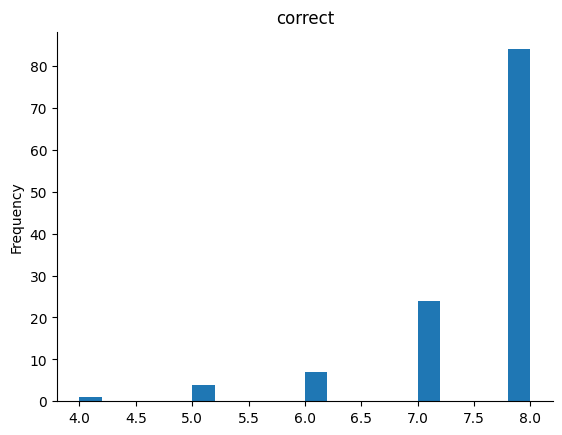

In [38]:
from matplotlib import pyplot as plt
df_resume['correct'].plot(kind='hist', bins=20, title='correct')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
worst_cases = df_resume.sort_values(by='accuracy').head(5)
print("\nWorst Case Resumes (Lowest Accuracy):")
print(worst_cases)

print("\nDistribution of Correct Fields per Resume:")
print(df_resume['correct'].value_counts().sort_index())


Worst Case Resumes (Lowest Accuracy):
    resume_id  correct  total  accuracy
106  26768723        4      8     0.500
18   91697974        5      8     0.625
37   46260230        5      8     0.625
50   13405733        5      8     0.625
35   20024870        5      8     0.625

Distribution of Correct Fields per Resume:
correct
4     1
5     4
6     7
7    24
8    84
Name: count, dtype: int64


In [40]:
rid = "26768723"
evaluate_resume(df_meta[df_meta['ID'] == rid]["Resume_str"].iloc[0], json.loads(parsed_results[rid]))

ResumeEval(evaluations=[FieldEval(field='name', correct=True, expected=None, comment='No name is present in the resume text, so null is correct.'), FieldEval(field='email', correct=True, expected=None, comment='No email is present in the resume text, so null is correct.'), FieldEval(field='phone', correct=True, expected=None, comment='No phone number is present in the resume text, so null is correct.'), FieldEval(field='skills', correct=False, expected="['Able to research and familiarize skill sets towards core technologies based on enthusiasm, dedication, and motivation', 'Knowledgeable with installation and configuration of Windows-based operating systems (Windows XP, Vista, 7, and 8)', 'Experienced with the installation and configuration of Ubuntu Linux whilst cognizant of Mac OS X interactions', 'Proficient with virtualization and highly skilled with configurations inside of VMware', 'Skilled with troubleshooting hardware and software issues within a network and support services en